# YouTube Analytics Project

This notebook demonstrates how to analyze YouTube video data using the YouTube Data API. It includes:

1. Setting up the environment and API access
2. Fetching channel information
3. Collecting video data
4. Basic data analysis and visualization


## Prerequisites
- Python 3.x
- YouTube Data API key (get one from [Google Cloud Console](https://console.cloud.google.com/))
- Required packages (install using `pip install -r requirements.txt`) 
- requests
- pandas
- numpy
- plotly
- wordcloud
- scikit-learn
- tqdm

## SETUP

In [8]:
import requests
import numpy as np
import pandas as pd
import plotly.express as px
import time
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [9]:
API_KEY = ###YOUR GOOGLE API KEY

## PULL CHANNELS

In [28]:

urls = [
    "https://www.youtube.com/@nitsanraiter",
    "https://www.youtube.com/@briddy",
    "https://www.youtube.com/@clarapeirce",
    "https://www.youtube.com/@urmomashley",
    "https://www.youtube.com/@sannevloet",
    "https://www.youtube.com/@claudiasulewski",
    "https://www.youtube.com/@sophdoeslife",
    "https://www.youtube.com/user/essiebutton",
    "https://www.youtube.com/@shanrellsstash",
    "https://www.youtube.com/@lindseymunette",
    "https://www.youtube.com/@emmaroseleger",
    "https://www.youtube.com/@claudiamariewalsh",
    "https://www.youtube.com/@hjevelynha",
    "https://www.youtube.com/@EmilyMariko",
    "https://www.youtube.com/@eloisedufka",
    "https://www.youtube.com/@EmmaMacDonald",
    "https://www.youtube.com/@MaggieMacDonaldVlogs",
    "https://www.youtube.com/@kaylieestewart",
    "https://www.youtube.com/@hauskris"



In [ ]:

def extract_query(url):
    match = re.search(r'youtube\.com/(@[\w\d\-]+|user/[\w\d\-]+)', url)
    return match.group(1) if match else None

def get_channel_id_from_handle(handle_or_username, api_key):
    if handle_or_username.startswith('@'):
        query = handle_or_username
    elif handle_or_username.startswith('user/'):
        query = handle_or_username.split('/')[1]
    else:
        return handle_or_username, "INVALID FORMAT"

    url = "https://www.googleapis.com/youtube/v3/search"
    params = {
        "part": "snippet",
        "q": query,
        "type": "channel",
        "maxResults": 1,
        "key": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()

    try:
        title = data['items'][0]['snippet']['channelTitle']
        channel_id = data['items'][0]['snippet']['channelId']
        return title, channel_id
    except (IndexError, KeyError):
        return query, "NOT FOUND"

In [ ]:
results = []

for url in urls:
    query = extract_query(url)
    if not query:
        results.append({"input_url": url, "channel_query": "INVALID", "channel_title": "", "channel_id": "INVALID"})
        continue

    title, channel_id = get_channel_id_from_handle(query, API_KEY)
    print(f"{title}: {channel_id}")
    results.append({
        "input_url": url,
        "channel_query": query,
        "channel_title": title,
        "channel_id": channel_id
    })
    time.sleep(1)  

df = pd.DataFrame(results)

In [4]:
valid_channels = df[df['channel_id'] != 'NOT FOUND']
channel_ids = valid_channels['channel_id'].tolist()
print(len(valid_channels), ' valid channels')

19  valid channels


## PULL VIDEOS

In [33]:
def fetch_videos_for_channel(channel_id, max_results=50):
    url = f"https://www.googleapis.com/youtube/v3/search"
    params = {
        "key": API_KEY,
        "channelId": channel_id,
        "part": "snippet",
        "order": "date",
        "maxResults": max_results,
        "type": "video"
    }
    r = requests.get(url, params=params).json()
    videos = []
    for item in r.get("items", []):
        videos.append({
            "channel_id": channel_id,
            "video_id": item["id"]["videoId"],
            "title": item["snippet"]["title"],
            "published_at": item["snippet"]["publishedAt"],
        })
    return videos

def get_recent_videos(channel_id, api_key, after_date="2025-01-01T00:00:00Z"):
    url = "https://www.googleapis.com/youtube/v3/search"
    params = {
        "part": "snippet",
        "channelId": channel_id,
        "publishedAfter": after_date,
        "type": "video",
        "order": "date",
        "maxResults": 50,
        "key": api_key
    }
    response = requests.get(url, params=params).json()
    videos = []
    for item in response.get("items", []):
        videos.append({
            "channel_id": channel_id,
            "video_id": item["id"]["videoId"],
            "title": item["snippet"]["title"],
            "published_at": item["snippet"]["publishedAt"]
        })
    return videos

In [34]:
all_videos = []
for cid in tqdm(channel_ids):
    vids = get_recent_videos(cid, API_KEY)
    all_videos.extend(vids)

video_df = pd.DataFrame(all_videos)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.54it/s]


##

## EDA

In [12]:
video_df['published_at'] = pd.to_datetime(video_df['published_at'])
video_df['week'] = video_df['published_at'].dt.to_period('W').apply(lambda r: r.start_time)

week_counts = video_df.groupby('week').size().reset_index(name='video_count')

fig = px.bar(week_counts, x='week', y='video_count',
             title="Weekly Video Uploads",
             labels={'video_count': 'Number of Videos', 'week': 'Week'})
fig.update_layout(width=900, height=600)
fig.show()

/var/folders/mx/cy8cr89935x92354w0qz6n280000gn/T/ipykernel_96287/2672265425.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  video_df['week'] = video_df['published_at'].dt.to_period('W').apply(lambda r: r.start_time)


In [47]:
video_df['month'] = video_df['published_at'].dt.to_period('M').astype(str)

month_counts = video_df.groupby('month').size().reset_index(name='video_count')
month_counts.head()

/var/folders/mx/cy8cr89935x92354w0qz6n280000gn/T/ipykernel_51742/1904518587.py:1: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,month,video_count
0,2025-01,77
1,2025-02,55
2,2025-03,66
3,2025-04,92
4,2025-05,80


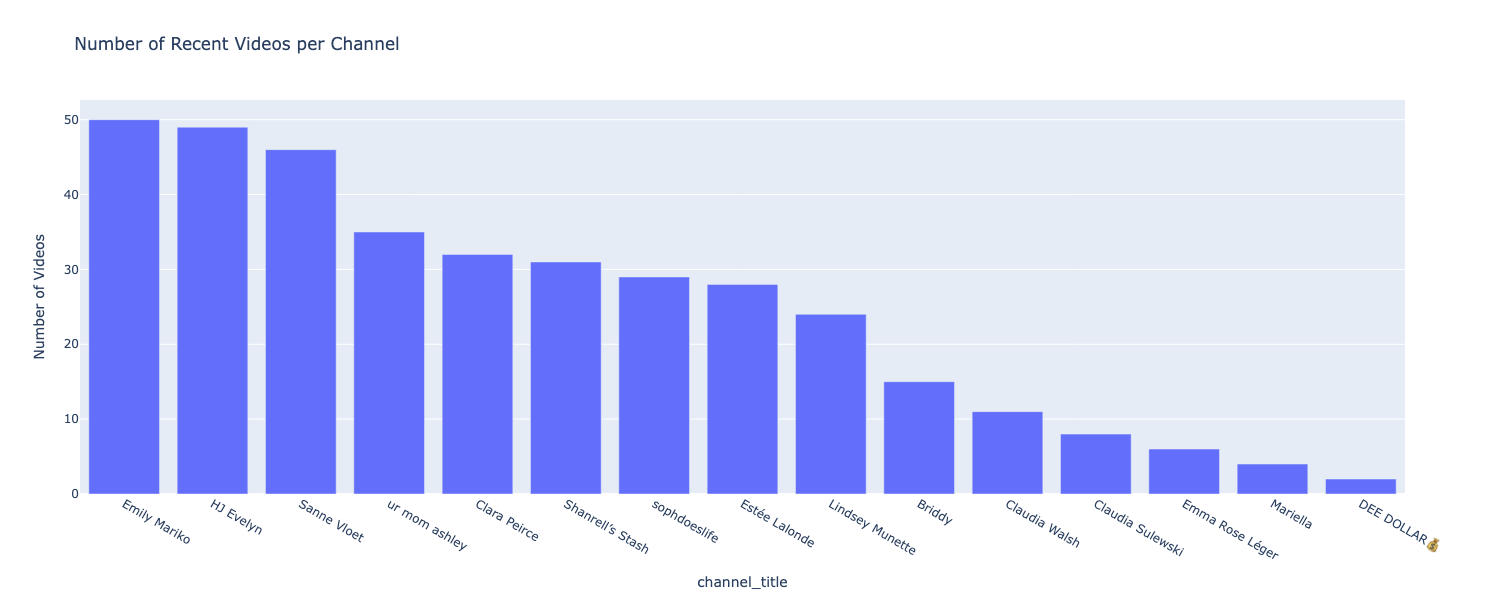

In [31]:
channel_counts = video_df['channel_id'].value_counts().reset_index()
channel_counts.columns = ['channel_id', 'video_count']

channel_info = df[['channel_id', 'channel_title']]
merged = pd.merge(channel_counts, channel_info, on='channel_id')

fig = px.bar(merged, x='channel_title', y='video_count',
             title="Number of Recent Videos per Channel",
             labels={'video_count': 'Number of Videos'})
fig.update_layout(width=900, height=600)
fig.show()

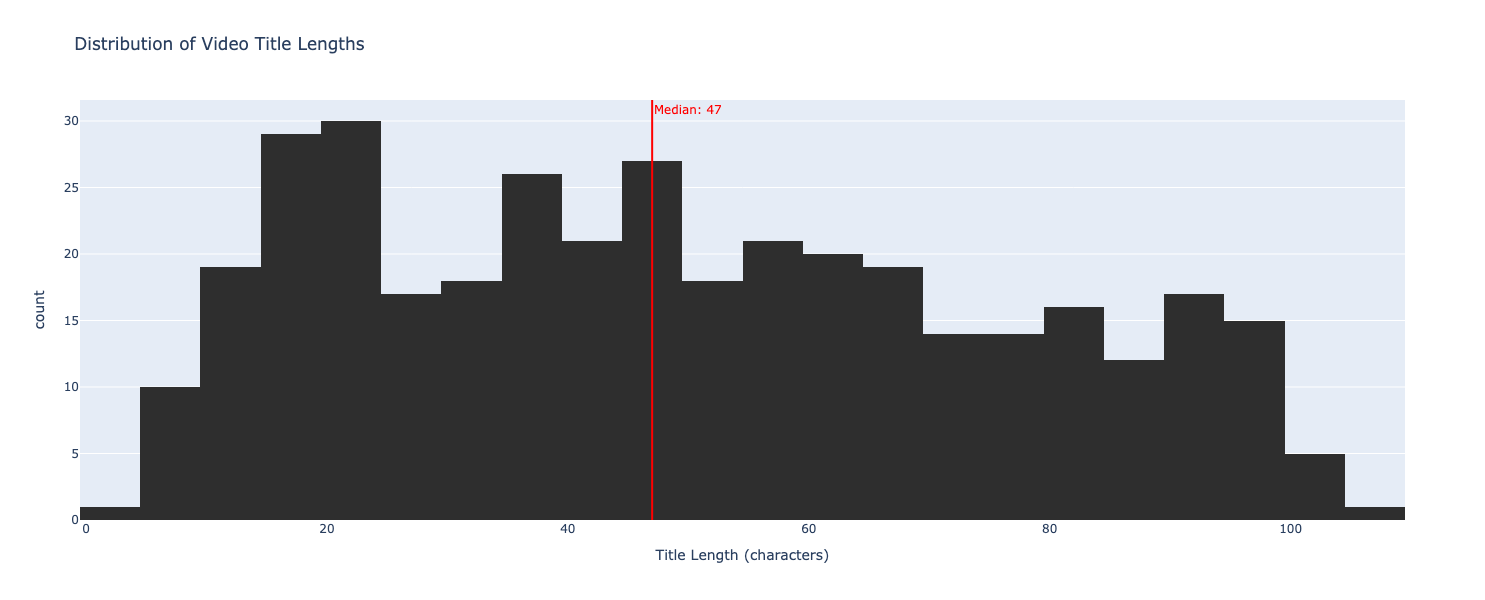

In [32]:
video_df['title_length'] = video_df['title'].str.len()
median_len = video_df['title_length'].median()

fig = px.histogram(video_df, x='title_length', nbins=30,
                   title="Distribution of Video Title Lengths",
                   labels={'title_length': 'Title Length (characters)'})

fig.update_traces(marker_color='#2e2e2e')  

fig.add_vline(x=median_len, line_color='red', line_width=2,
              annotation_text=f"Median: {int(median_len)}",
              annotation_position="top right",
              annotation_font_color="red")

fig.update_layout(
    width=900, height=600
)

# fig.show()

## PULL VIDEO STATS

In [34]:
def fetch_video_stats(video_ids, api_key):
    stats = []
    for i in range(0, len(video_ids), 50):  # API allows max 50 IDs per call
        batch = video_ids[i:i+50]
        url = "https://www.googleapis.com/youtube/v3/videos"
        params = {
            "part": "statistics,snippet",
            "id": ",".join(batch),
            "key": api_key
        }
        response = requests.get(url, params=params).json()

        for item in response.get("items", []):
            vid_id = item["id"]
            stats.append({
                "video_id": vid_id,
                "title": item["snippet"]["title"],
                "view_count": int(item["statistics"].get("viewCount", 0)),
                "like_count": int(item["statistics"].get("likeCount", 0)),
                "comment_count": int(item["statistics"].get("commentCount", 0))
            })
    return stats

video_ids = video_df['video_id'].dropna().unique().tolist()
video_stats = fetch_video_stats(video_ids, API_KEY)

stats_df = pd.DataFrame(video_stats)
full_df = pd.merge(video_df, stats_df, on=["video_id", "title"], how="left")

In [14]:
full_df = full_df[full_df.view_count < 3000000] #tinker around
full_df.view_count.max()

np.float64(2355212.0)

## MORE EDA

In [27]:
fig = px.scatter(
    full_df, 
    x='view_count', 
    y='like_count',
    color='title_length',  # This will create a gradient based on title length
    color_continuous_scale='Viridis',  # You can change this to other color scales like 'Plasma', 'Inferno', etc.
    title='View Count vs Like Count (Colored by Title Length)',
    labels={
        'view_count': 'View Count',
        'like_count': 'Like Count',
        'title_length': 'Title Length'
    }
)

# Add the OLS line
fig.add_traces(px.line(
    x=full_df['view_count'], 
    y=full_df['predicted_like']
).data)

fig.show()

In [19]:
results = px.get_trendline_results(fig)
summary = results.iloc[0]["px_fit_results"].summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     280.4
Date:                Wed, 28 May 2025   Prob (F-statistic):           5.22e-49
Time:                        11:49:49   Log-Likelihood:                -4392.7
No. Observations:                 440   AIC:                             8789.
Df Residuals:                     438   BIC:                             8798.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1592.4594    271.218      5.872      0.0

## CLEANING / FE

In [63]:
SPONSOR_TAGS = [
    "sponsored", "ad", "gifted", "partnership", 
    "paid", "affiliate", "promo code", "brand deal", 
    "collab", "collaboration", "ambassador"
]

def is_not_sponsored(title):
    title = title.lower()
    return not any(tag in title for tag in SPONSOR_TAGS)

filtered_df = full_df[full_df['title'].apply(is_not_sponsored)]
len(filtered_df)

402

In [ ]:
filtered_df['engmt_rate'] = filtered_df['like_count'] / filtered_df['view_count']

alpha = 1
filtered_df['engmt_h'] = (filtered_df['like_count'] + (alpha * filtered_df['comment_count'])) / filtered_df['view_count']

filtered_df['clean_title'] = filtered_df['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

display(filtered_df.engmt_h.min(), filtered_df.engmt_h.max())


## MODEL

In [ ]:

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(filtered_df['clean_title'])
y = filtered_df['engmt_h']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rmse

In [ ]:
y_all_pred = model.predict(X)

# Create a DataFrame for plotting
scatter_all_df = pd.DataFrame({
    "Actual": y,     dd      # true values from full_df['engmt_rate']
    "Predicted": y_all_pred
})

# Plot
fig = px.scatter(
    scatter_all_df,
    x="Actual",
    y="Predicted",
    title="Predicted vs Actual Engagement Rate (Full Dataset)",
    labels={"Actual": "Actual Engagement Rate", "Predicted": "Predicted Engagement Rate"},
    opacity=0.6
)

# Add diagonal reference line
fig.add_shape(
    type='line',
    x0=0, y0=0, x1=0.2, y1=0.2,
    line=dict(dash='dash', color='red')
)

fig.update_layout(
    width=800,
    height=600,
)

fig.show()

## HYPERPARAM TUNING

In [11]:
alphas = [.05, .08, 0.1, .3]

ridge = Ridge()
grid = GridSearchCV(
    ridge,
    param_grid={'alpha': alphas},
    scoring='neg_root_mean_squared_error',
    cv=5,
    return_train_score=True
)

grid.fit(X_train, y_train)

results_df = pd.DataFrame(grid.cv_results_)[['param_alpha', 'mean_test_score']]
results_df['RMSE'] = -results_df['mean_test_score']  # convert from negative RMSE
results_df = results_df.rename(columns={'param_alpha': 'Alpha'})

results_df = results_df.sort_values('RMSE').reset_index(drop=True)
results_df

,Alpha,mean_test_score,RMSE
0,0.08,-0.027997,0.027997
1,0.10,-0.027999,0.027999
2,0.05,-0.028027,0.028027
3,0.30,-0.028291,0.028291
